<p style="font-family: Arial; font-size:2.75em;color:purple; font-style:bold">
Cluster Analysis

In [1]:
%autosave 0

Autosave disabled


In [2]:
#from customplot import *
import itertools
#import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from IPython.display import Image
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

In [23]:
def plot_confusion_matrix(cm, classes, groups,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(classes))
    tick_marks = np.arange(len(groups))
    plt.xticks(tick_marks, groups, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
def printcfm(y_test,y_pred,groups,title='confusion matrix'):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Sem Perda','Perda'], groups=groups,
                      title=title)

In [5]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [6]:
#Setando configurações de visualização
pd.options.display.max_rows=350
pd.options.display.max_columns=60

In [7]:

#df=pd.read_csv('baseProjeto_entradaModelo.csv', index_col=0)
# Somente dados da Fase 1
dfFase1=pd.read_csv('baseProjeto_entradaModelo_fase1.csv', index_col=0)
df=dfFase1

In [8]:
df.head(10)

,AREA,POÇO,ID_INTERVALO,ATRIB_MED1,ATRIB_MAX1,ATRIB_DIST1,DIFP,MGP1,MGP2,MGP3,MGP4,MGP5,MGP6,MGP7,MGP8,MGP9,MGP10,MGP11,MGP12,MGP13,MGP14,Perda30,PerdaAPI,PerdaPS,PERDA_MAX
1,C1,C1P1,A1,0.08,0.54,1000.0,0.610,1,1,1,1,0,0,0,1,1,1,0,0,0,0,1,1,0,100.0
2,C1,C1P1,A2,0.05,0.05,1000.0,0.540,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,12.0
3,C1,C1P1,A3,0.05,0.05,1000.0,0.610,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,10.0
4,C1,C1P1,B1,0.13,0.92,1000.0,0.630,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0.0
5,C1,C1P2,A1,0.16,0.83,300.0,0.420,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,999.0
7,C1,C1P2,A3,0.46,0.95,17.0,0.604,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,500.0
8,C1,C1P2,B1,0.12,0.84,127.0,0.695,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,450.0
9,C1,C1P3,A1,0.05,0.05,1000.0,0.470,0,1,1,1,0,0,0,0,1,1,1,1,0,1,1,1,0,120.0
11,C1,C1P3,A3,0.26,0.95,120.0,0.363,0,1,1,1,0,0,0,0,1,1,1,1,0,1,1,1,0,60.0
12,C1,C1P3,B1,0.05,0.05,1000.0,0.350,0,1,1,1,0,0,0,0,1,1,1,1,0,1,1,1,1,300.0


In [9]:
print(df.columns)

Index(['AREA', 'POÇO', 'ID_INTERVALO', 'ATRIB_MED1', 'ATRIB_MAX1',
       'ATRIB_DIST1', 'DIFP', 'MGP1', 'MGP2', 'MGP3', 'MGP4', 'MGP5', 'MGP6',
       'MGP7', 'MGP8', 'MGP9', 'MGP10', 'MGP11', 'MGP12', 'MGP13', 'MGP14',
       'Perda30', 'PerdaAPI', 'PerdaPS', 'PERDA_MAX'],
      dtype='object')


In [10]:
# categorize_questions = lambda x: x.astype('category')
# questions = [ 'MGP1', 'MGP2', 'MGP3', 'MGP4', 'MGP5', 'MGP6', 'MGP7', 'MGP8', 'MGP9',
#        'MGP10', 'MGP11', 'MGP12', 'MGP13', 'MGP14']
# df[questions] = df[questions].apply(categorize_questions,axis=0)

In [11]:
X=df[['ATRIB_MED1', 'ATRIB_MAX1',
       'ATRIB_DIST1', 'DIFP', 'MGP1', 'MGP2', 'MGP3', 'MGP4', 'MGP5', 'MGP6',
       'MGP7', 'MGP8', 'MGP9', 'MGP10', 'MGP11', 'MGP12', 'MGP13', 'MGP14']]

In [12]:
X;

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 1 to 125
Data columns (total 18 columns):
ATRIB_MED1     120 non-null float64
ATRIB_MAX1     120 non-null float64
ATRIB_DIST1    120 non-null float64
DIFP           120 non-null float64
MGP1           120 non-null int64
MGP2           120 non-null int64
MGP3           120 non-null int64
MGP4           120 non-null int64
MGP5           120 non-null int64
MGP6           120 non-null int64
MGP7           120 non-null int64
MGP8           120 non-null int64
MGP9           120 non-null int64
MGP10          120 non-null int64
MGP11          120 non-null int64
MGP12          120 non-null int64
MGP13          120 non-null int64
MGP14          120 non-null int64
dtypes: float64(4), int64(14)
memory usage: 17.8 KB


In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 1 to 125
Data columns (total 18 columns):
ATRIB_MED1     120 non-null float64
ATRIB_MAX1     120 non-null float64
ATRIB_DIST1    120 non-null float64
DIFP           120 non-null float64
MGP1           120 non-null int64
MGP2           120 non-null int64
MGP3           120 non-null int64
MGP4           120 non-null int64
MGP5           120 non-null int64
MGP6           120 non-null int64
MGP7           120 non-null int64
MGP8           120 non-null int64
MGP9           120 non-null int64
MGP10          120 non-null int64
MGP11          120 non-null int64
MGP12          120 non-null int64
MGP13          120 non-null int64
MGP14          120 non-null int64
dtypes: float64(4), int64(14)
memory usage: 17.8 KB


In [15]:
y = df['Perda30']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=21)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold">
1 - K-means</p>
<br>
k-means clustering, or Lloyd’s algorithm [1], is an iterative, data-partitioning algorithm that assigns n observations to exactly one of k clusters defined by centroids, where k is chosen before the algorithm starts.

The algorithm proceeds as follows:
<ol>
<li>Choose k initial cluster centers (centroid). For example, choose k observations at random (by using 'Start','sample') or use the k-means ++ algorithm for cluster center initialization (the default).</li>

<li>Compute point-to-cluster-centroid distances of all observations to each centroid.</li>

<li>Compute the average of the observations in each cluster to obtain k new centroid locations.</li>

<li>Repeat steps 2 through 4 until cluster assignments do not change, or the maximum number of iterations is reached.</li>

The k-means algorithm divides a set of $N$ samples $X$ into $K$ disjoint clusters $C$, each described by the mean $\mu_j$ of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from $X$, although they live in the same space. The K-means algorithm (implemented in sklearn) aims to choose centroids that minimise the inertia, or within-cluster sum of squared criterion:

$$ WSS \!=\! Inertia_\!=\!{\sum_{j=1}^{K}}\Bigg({\sum_{x_i\in Cluster}^{K}(x_i-c_j)²}\Bigg)$$
<br><center>Sum of squared distances of samples to their closest cluster center.</center>

There are others objective function to determine the best clusters number
<ul>
    <li>Partition Entropy</li>
    <li>Partitioning Coeficient</li>
    <li>Modified Partition Entropy</li>
    <li>Proportion Exponent</li>
       

According to [2] the Euclidean and Mahattan distances are distance measures used to data points in euclidean space. Cosine similarity and Jaccard distance are used to documents.

Evaluating the Inertia as objective function for $K$ clusters

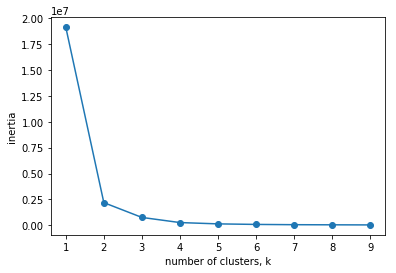

In [17]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k)
        
    # Fit model to samples
    kmeans.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

<p style="font-family: Arial; font-size:1.5em;color:purple; font-style:bold">
1.1 - K-Means (K=3)</p>

Using K-means with normalized $X$

In [18]:
scaler = StandardScaler()
kmeans = KMeans(n_clusters=3)
pipeline = make_pipeline(scaler, kmeans)

# Fit model to points
pipeline.fit(X)

# Determine the cluster labels of new_points: labels
y_cluster = pipeline.predict(X)

# Print cluster labels of new_points
#print(y_cluster)

In [19]:
# Create a DataFrame with labels and varieties as columns: df
dfcluster = pd.DataFrame({'labels': y_cluster, 'Perda': y})

# Create crosstab: ct
ct = pd.crosstab(dfcluster['labels'],dfcluster['Perda'])

# Display ct
print(ct)

Perda    0   1
labels        
0       41   1
1       29  16
2       15  18


Confusion matrix, without normalization


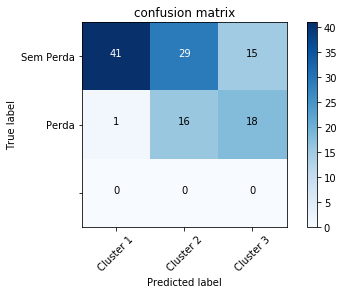

In [26]:
printcfm(dfcluster['Perda'],dfcluster['labels'],['Cluster 1','Cluster 2','Cluster 3'],title='confusion matrix')

Using K-means without normalization $X$

In [28]:
kmeans = KMeans(n_clusters=3)

# Fit model to points
kmeans.fit(X)

# Determine the cluster labels of new_points: labels
y_cluster = kmeans.predict(X)

# Print cluster labels of new_points
#print(y_cluster)

In [29]:
# Create a DataFrame with labels and varieties as columns: df
dfcluster = pd.DataFrame({'labels': y_cluster, 'Perda': y})

# Create crosstab: ct
ct = pd.crosstab(dfcluster['labels'],dfcluster['Perda'])

# Display ct
print(ct)

Perda    0   1
labels        
0       35   7
1       30  19
2       20   9


Confusion matrix, without normalization


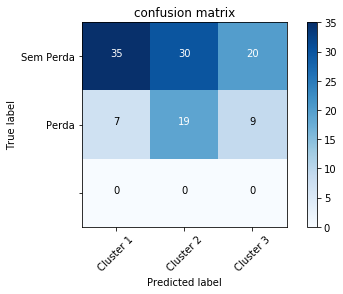

In [30]:
printcfm(dfcluster['Perda'],dfcluster['labels'],['Cluster 1','Cluster 2','Cluster 3'],title='confusion matrix')

<p style="font-family: Arial; font-size:1.5em;color:purple; font-style:bold">
1.2 - K-Means (K=2)</p>

Using K-means with normalized $X$

In [31]:
scaler = StandardScaler()
kmeans = KMeans(n_clusters=2)
pipeline = make_pipeline(scaler, kmeans)

# Fit model to points
pipeline.fit(X)

# Determine the cluster labels of new_points: labels
y_cluster = pipeline.predict(X)

# Print cluster labels of new_points
#print(y_cluster)

In [32]:
# Create a DataFrame with labels and varieties as columns: df
dfcluster = pd.DataFrame({'labels': y_cluster, 'Perda': y})

# Create crosstab: ct
ct = pd.crosstab(dfcluster['labels'],dfcluster['Perda'])

# Display ct
print(ct)

Perda    0   1
labels        
0       24  28
1       61   7


Confusion matrix, without normalization


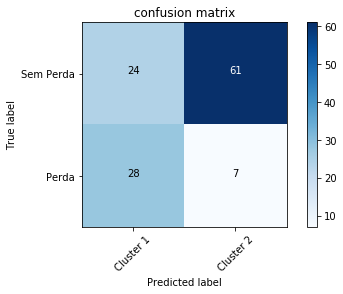

In [34]:
printcfm(dfcluster['Perda'],dfcluster['labels'],['Cluster 1','Cluster 2'],title='confusion matrix')

Using K-means without normalization $X$

In [35]:
kmeans = KMeans(n_clusters=2)

# Fit model to points
kmeans.fit(X)

# Determine the cluster labels of new_points: labels
y_cluster = kmeans.predict(X)

# Print cluster labels of new_points
#print(y_cluster)

In [36]:
# Create a DataFrame with labels and varieties as columns: df
dfcluster = pd.DataFrame({'labels': y_cluster, 'Perda': y})

# Create crosstab: ct
ct = pd.crosstab(dfcluster['labels'],dfcluster['Perda'])

# Display ct
print(ct)

Perda    0   1
labels        
0       48  27
1       37   8


Confusion matrix, without normalization


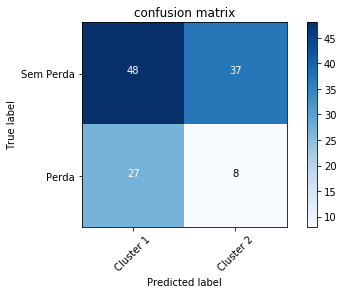

In [37]:
printcfm(dfcluster['Perda'],dfcluster['labels'],['Cluster 1','Cluster 2'],title='confusion matrix')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold">
2 - Hierarchical clustering</p>

According to [2] Hierarchical clustering techniques are important clustering methods. As with K-means, these approaches are relatively old but they are widespread used. There are two basic approaches:
<ol>
<li>**Agglomerative**:
Start with the points as individual clusters and, at each
step, merge the closest pair of clusters. This approach is based in proximity values. This techniques are the moste commom.</li>
<li>**Divisive**: Start with onecluster, at each step, split a cluster until only individual points remain.</li>

In [38]:
X.shape

(120, 18)

In [39]:
Z = linkage(X, method='ward', metric='euclidean', optimal_ordering=True)

Method: The linkage algorithm to use
<ul>
    <li>'Single': for all points $i$ in cluster $u$ and $j$ in cluster $v$. This is also known as the Nearest Point Algorithm.
    <br>EQUATION</li>
    <li>'Complete': for all points $i$ in cluster $u$ and $j$ in cluster $v$.This is also known by the Farthest Point Algorithm or Voor Hees Algorithm.
    <br>EQUATION</li>
    <li>'Average': for all points $i$ and $j$ where |$u$| and |$v$| are the cardinalities of clusters $u$ and $v$, respectively. This is also called the UPGMA algorithm.
    <br>EQUATION</li>
    <li>'weighted': where cluster $u$ was formed with cluster $s$ and $t$ and $v$ is a remaining cluster in the forest. (also called WPGMA)</li>
    <li>'centroid': where $c_s$ and $c_t$ are the centroids of clusters $s$ and $t$, respectively. When two clusters $u$ and  are combined into a new cluster , the new centroid is computed over all the original objects in clusters $s$ and $t$. The distance then becomes the Euclidean distance between the centroid of $u$ and the centroid of a remaining cluster $v$ in the forest. This is also known as the UPGMC algorithm. <br>EQUATION</li>
    <li>'median': (   ) like the centroid method. When two clusters $s$ and $t$  are combined into a new cluster $u$, the average of centroids $s$ and $t$ give the new centroid $u$. This is also known as the WPGMC algorithm.</li>
    <li>'ward': uses the Ward variance minimization algorithm. The new entry (   ) is computed as follows,<br>
EQUATION<br>
where  is the newly joined cluster consisting of clusters  and ,  is an unused cluster in the forest, , and  is the cardinality of its argument. This is also known as the incremental algorithm.</li>

In [40]:
Z;

In [41]:
#c, coph_dists = cophenet(Z, pdist(X));
#c

In [42]:
Z[0]
#Z[N]

array([34., 35.,  0.,  2.])

Explanation: 
Format: [idx1, idx2, dist, sample_count].
In its N+1 iteration the linkage algorithm merged the two clusters (original samples here) with indices idx1 and idx2, as they only had a distance of dist. This created a cluster with a total of samples_count.

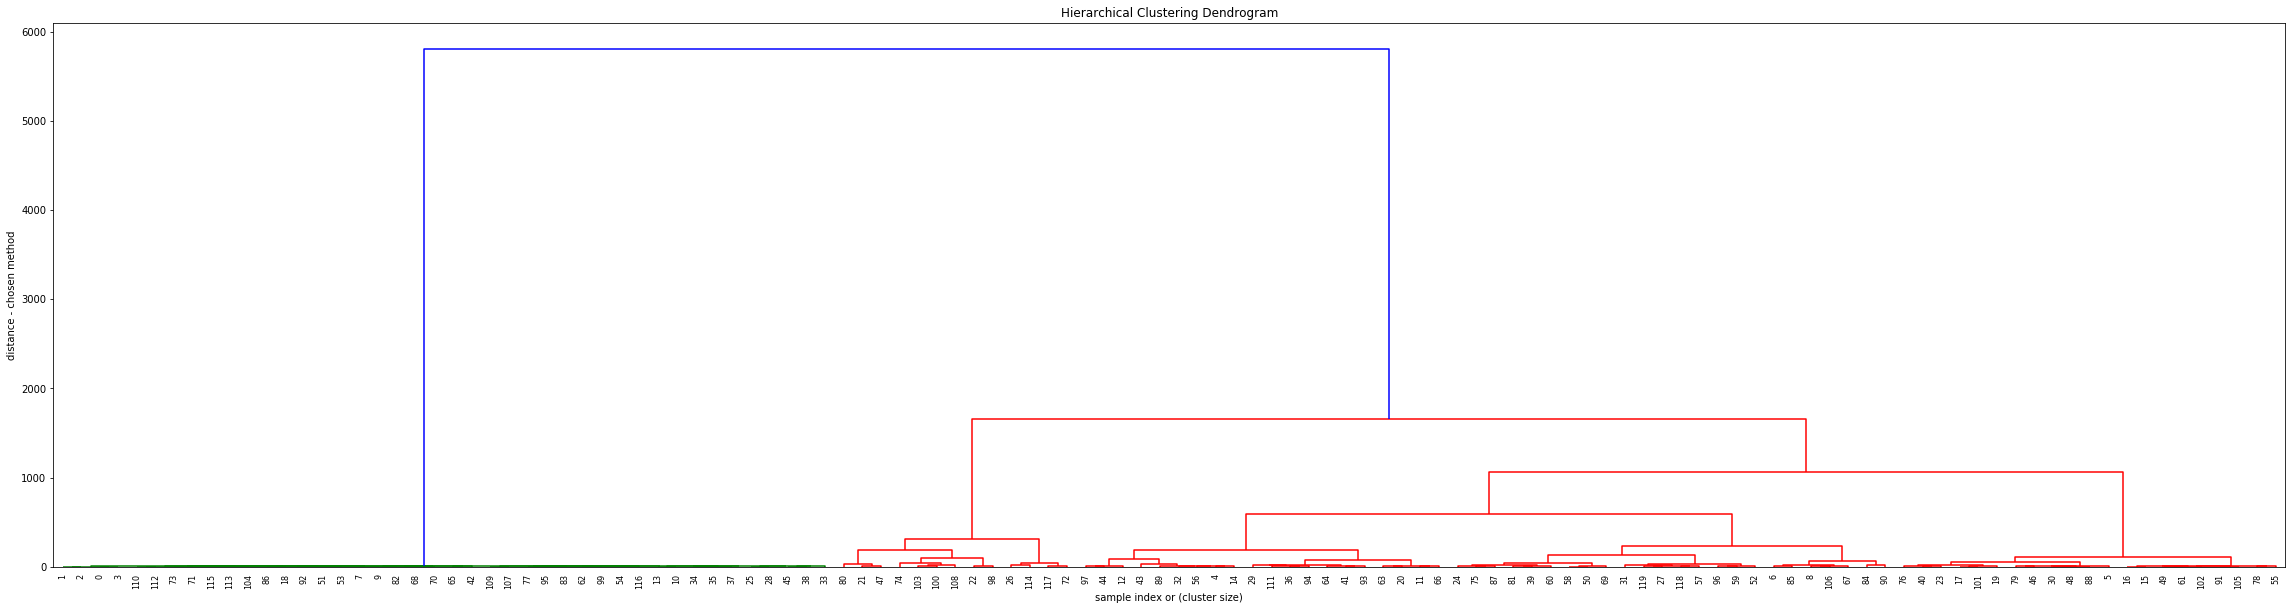

In [43]:
# calculate full dendrogram
plt.figure(figsize=(40, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance - chosen method')
dendrogram(
    Z,
    #truncate_mode='lastp',  # show only the last p merged clusters
    #p=12,  # show only the last p merged clusters
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    #show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

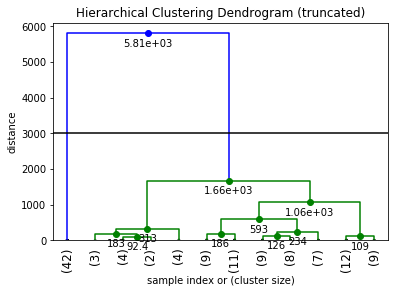

In [44]:
# set cut-off
max_d = 3000  # max_d as in max_distance

fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

In [45]:
Z[-4:,:]

array([[ 232.  ,  233.  ,  592.5 ,   44.  ],
       [ 235.  ,  229.  , 1063.86,   65.  ],
       [ 234.  ,  236.  , 1660.63,   78.  ],
       [ 195.  ,  237.  , 5807.9 ,  120.  ]])

Inspecting "the elbow method" to choose the number of clusters

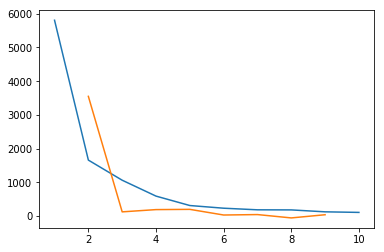

clusters: 2


In [46]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

In [50]:
from scipy.cluster.hierarchy import fcluster
z_clusters = fcluster(Z, max_d, criterion='distance')
z_clusters;
z_clusters=z_clusters-1;

In [51]:
# Create a DataFrame with labels and varieties as columns: df
dfcluster = pd.DataFrame({'labels': z_clusters, 'Perda': y})

# Create crosstab: ct
ct = pd.crosstab(dfcluster['labels'],dfcluster['Perda'])

# Display ct
print(ct)

Perda    0   1
labels        
0       35   7
1       50  28


Confusion matrix, without normalization


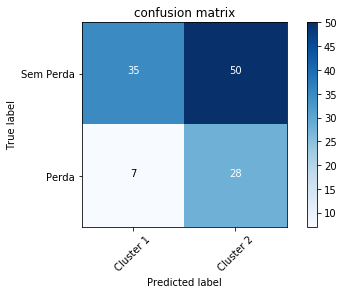

In [52]:
printcfm(dfcluster['Perda'],dfcluster['labels'],['Cluster 1','Cluster 2'],title='confusion matrix')

In [54]:
k=2
z_clusters=fcluster(Z, k, criterion='maxclust')
z_clusters;
z_clusters=z_clusters-1;

In [55]:
# Create a DataFrame with labels and varieties as columns: df
dfcluster = pd.DataFrame({'labels': z_clusters, 'Perda': y})

# Create crosstab: ct
ct = pd.crosstab(dfcluster['labels'],dfcluster['Perda'])

# Display ct
print(ct)

Perda    0   1
labels        
0       35   7
1       50  28


Confusion matrix, without normalization


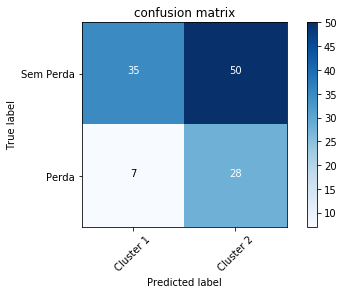

In [56]:
printcfm(dfcluster['Perda'],dfcluster['labels'],['Cluster 1','Cluster 2'],title='confusion matrix')

[2] Affirms that that agglomerative hierarchical clustering cannot be viewed as globally optimizing an objective function.

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold">
3 - DBSCAN</p>

Noisy samples are given the label -1.

Using DBSCAN with normalized $X$

In [ ]:
db = DBSCAN(eps=3.5, min_samples=5, metric='euclidean', 
                metric_params=None, algorithm='auto', leaf_size=30, 
                p=None, n_jobs=-1)

In [ ]:
scaler = StandardScaler()
pipeline = make_pipeline(scaler, db)

# Fit model to points
pipeline.fit(X)

# Determine the cluster labels of new_points: labels
y_cluster = pipeline.fit_predict(X)

# Print cluster labels of new_points
#print(y_cluster)

In [ ]:
# Create a DataFrame with labels and varieties as columns: df
dfcluster = pd.DataFrame({'labels': y_cluster, 'Perda': y})

# Create crosstab: ct
ct = pd.crosstab(dfcluster['labels'],dfcluster['Perda'])

# Display ct
print(ct)

Using DBSCAN without normalized $X$

In [ ]:
db.fit(X);

db.fit_predict(X);

In [ ]:
db.labels_.shape

In [ ]:
db.core_sample_indices_.shape ;

In [ ]:
db.core_sample_indices_;

In [ ]:
db.components_.shape 

In [ ]:
db.components_;

In [ ]:
# Create a DataFrame with labels and varieties as columns: df
dfcluster = pd.DataFrame({'labels': db.labels_, 'Perda': y})

# Create crosstab: ct
ct = pd.crosstab(dfcluster['labels'],dfcluster['Perda'])

# Display ct
print(ct)

[1] Lloyd, Stuart P. “Least Squares Quantization in PCM.” IEEE Transactions on Information Theory. Vol. 28, 1982, pp. 129–137.
<br>[2] Pang-Ning Tan, Michael Steinbach, and Vipin Kumar. 2005. Introduction to Data Mining, (First Edition). Addison-Wesley Longman Publishing Co., Inc., Boston, MA, USA.
<br>[3]https://www.mathworks.com/help/stats/kmeans.html
<br>[4]http://scikit-learn.org/stable/modules/clustering.html#
<br>[5]https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
<br>[6]https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html